# This notebook is used for IBM DATA SCIENCE COURSE CAPSTONE PROJECT

In [1]:
import numpy as np
import pandas as pd
import requests
import random
import folium
from geopy.geocoders import Nominatim
import folium
import requests
import json

# Part 1, Explore the cities dataset. Use clsutering technique to find cities similar to Seattle.

In [2]:
#read the cities dataset
cities = pd.read_csv('uscities.csv')
#cities.head()

## Since Amazon's first headquarter is on the west coast of the U.S., we might want to put the 2nd headquarter in the east half of the country. We can do so by using the longitude.

In [3]:
#Getting us's central coordinates
address = 'United States'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the U.S.are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the U.S.are 39.7837304, -100.4458825.


In [4]:
east_cities = cities[cities.lng > longitude]
east_cities.shape

(22695, 19)

## Further filtering the dataset to only keep the cities with large population(top 10%)

In [5]:
threshold = np.percentile(cities.population,90)
east_cities = east_cities[east_cities.population > threshold]
east_cities.shape

(2094, 19)

In [6]:
#plotting the cities on the map
map = folium.Map(location=[latitude, longitude], zoom_start=4)
for lat, lng, label in zip(east_cities['lat'], east_cities['lng'],east_cities['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    
#map

## Now we can clean the dataset to do cluster

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#concating seattle into the dataset
seattle = cities.loc[cities.city == 'Seattle']
east_cities = pd.concat(objs = [east_cities,seattle])
east_cities.shape

(2095, 19)

In [9]:
#only select the columns that will be used for clustering
cols = ['population','density','military','incorporated','timezone','ranking']
X = east_cities[cols]
X.shape

(2095, 6)

In [10]:
#encode categorical data using label encoder
for col in ['military','incorporated','timezone']:
    encoder = LabelEncoder()
    X[col]=encoder.fit_transform(X[col])
X.head()

/Users/gideon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,population,density,military,incorporated,timezone,ranking
638,20864.0,438.0,0,1,8,3
660,34132.0,715.0,0,1,8,3
666,20401.0,1379.0,0,0,8,3
667,71106.0,2517.0,0,1,8,2
682,27087.0,308.0,0,1,8,3


(array([2.033e+03, 0.000e+00, 8.000e+00, 0.000e+00, 0.000e+00, 4.400e+01,
        0.000e+00, 1.000e+00, 0.000e+00, 9.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

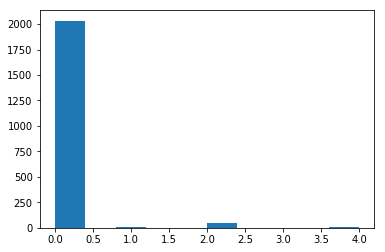

In [11]:
#use k = 5, do a kmean clustering
n = 5
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
kmeans.labels_

plt.hist(kmeans.labels_)

In [12]:
#get the label for Seattle
east_cities.insert(0,'labels',kmeans.labels_)
east_cities.loc[east_cities.city == 'Seattle']

,labels,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
106,4,Seattle,Seattle,WA,Washington,53033,King,53033,King,47.6211,-122.3244,3643765.0,3336.0,polygon,False,True,America/Los_Angeles,1,98109 98108 98104 98107 98106 98101 98103 9810...,1840097260


In [13]:
#get all cities with the label 4, same as Seattle
options = east_cities[east_cities.labels == 4]
options.shape

(9, 20)

In [14]:
#There are 8 cities to be our options, let see what they are.
#We keep the Seattle for the next part of this project
city_list = options['city'].values
city_list

array(['Tampa', 'San Antonio', 'Queens', 'Brooklyn', 'Baltimore',
       'St. Louis', 'Minneapolis', 'Detroit', 'Seattle'], dtype=object)

# Part 2, use Foursquare API to find the neighborhood that is the most similar to Amazon's first headquarter.

In [15]:
#build a new dataframe called candidates
candidates = pd.DataFrame(columns = ['city'])
candidates['city'] = city_list
#candidates

In [16]:
#get the coordinates for the list of candidates

lat = []
lng = []
for add in city_list:
    address = add

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of the {} are {}, {}.'.format(address,latitude, longitude))
    
    lat.append(latitude)
    lng.append(longitude)

The geograpical coordinate of the Tampa are 27.9477595, -82.458444.
The geograpical coordinate of the San Antonio are 29.4246002, -98.4951405.
The geograpical coordinate of the Queens are 40.6524927, -73.7914214158161.
The geograpical coordinate of the Brooklyn are 40.6501038, -73.9495823.
The geograpical coordinate of the Baltimore are 39.2908816, -76.610759.
The geograpical coordinate of the St. Louis are 38.6268039, -90.1994097.
The geograpical coordinate of the Minneapolis are 44.9706705, -93.268217735811.
The geograpical coordinate of the Detroit are 42.3315509, -83.0466403.
The geograpical coordinate of the Seattle are 47.6038321, -122.3300624.


In [17]:
candidates['Latitude']=lat
candidates['Longitude']=lng
#candidates
#now we have a dataframe, let's explore using Foursquare API

In [18]:
#get nearby venues
CLIENT_ID = 'SLOTL4BOPTRC0G2P4OH13AXOIZLVZFNFP3EOD14CYQ32R3FW' # your Foursquare ID
CLIENT_SECRET = 'EOMYXZBVSGBIGO32XKWCHRNCWA2SZ40HYLK50J1E4XTZGJVR' # your Foursquare Secret
LIMIT = 200
radius = 1000
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
venues = getNearbyVenues(names=candidates['city'],
                                   latitudes=candidates['Latitude'],
                                   longitudes=candidates['Longitude']
                                  )
venues.shape

Tampa
San Antonio
Queens
Brooklyn
Baltimore
St. Louis
Minneapolis
Detroit
Seattle


(491, 7)

In [20]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 146 uniques categories.


In [21]:
#def a function to get dataframe desired
def get_dataframe(city):
    df = venues[venues.Neighborhood == city].groupby('Venue Category').count()
    df.rename(columns = {'Neighborhood':city},inplace=True)
    df = df.T
    df = df.head(1)
    return df

In [22]:
#build a new dataframe for analysis
candidates_venues = pd.DataFrame()
for city in city_list:
    df = get_dataframe(city)
    candidates_venues = pd.concat(objs = [df,candidates_venues])
    
candidates_venues.reset_index()
candidates_venues

/Users/gideon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,ATM,Airport Lounge,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Theater,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
Seattle,NaN,NaN,NaN,1.0,NaN,NaN,1.0,2.0,NaN,1.0,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0
Detroit,NaN,NaN,6.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0
Minneapolis,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
St. Louis,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Baltimore,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
Brooklyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Queens,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
San Antonio,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Tampa,NaN,NaN,1.0,NaN,NaN,1.0,NaN,2.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [23]:
#Cleaning the dataset, fill NaN value with 0
candidates_venues.fillna(0,inplace=True)
#candidates_venues

In [24]:
#use PCA to get the city that is most similar to Seattle
pca = PCA(n_components = 2)
pcs = pca.fit_transform(candidates_venues)
candidates_venues.insert(0,'pc1',pcs[:,0])
candidates_venues.insert(0,'pc2',pcs[:,1])

In [29]:
df=candidates_venues[['pc1','pc2']]

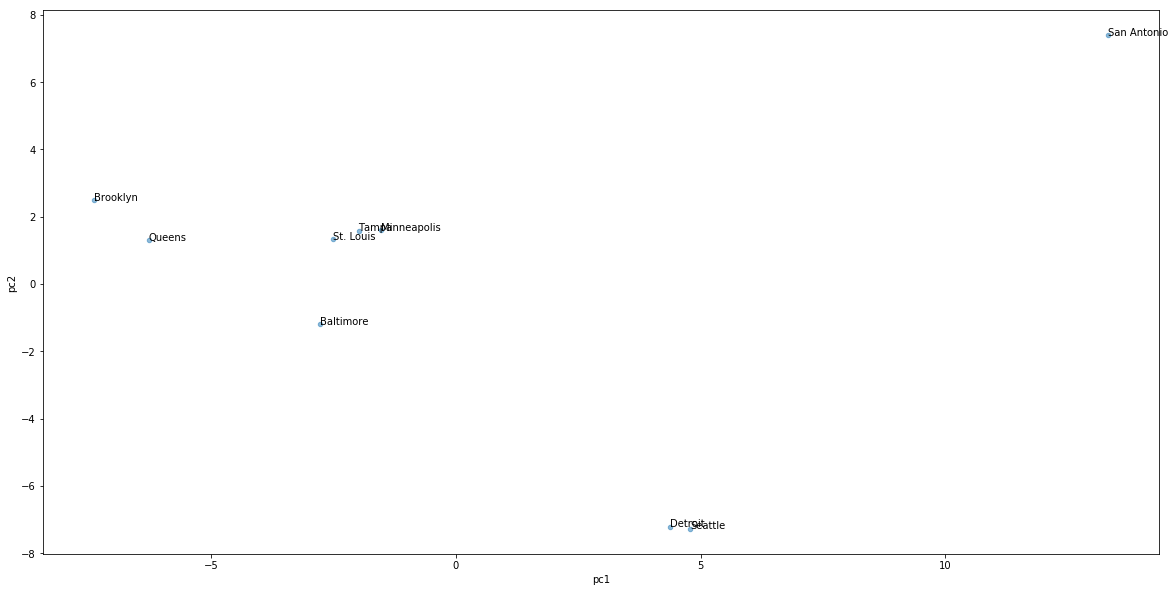

In [30]:
#create a df for plotting
ax = df.plot.scatter(x='pc1', y='pc2', alpha=0.5,figsize=(20,10))
for i, txt in enumerate(df.index):
    ax.annotate(txt, (df.pc1.iat[i],df.pc2.iat[i]))
plt.show()

# Final Conclusion: Now we can see the city most similar to Seattle is  Detroit. so Detroit is our final answer